# Lunar Landing using Reinforcement Learning

*by Vishal Shetty, December 14 , 2021* 

### Index

1. Introduction
2. Code for Lunar Lander DQN agent with Experience replay buffer and its results
3. Problems with Online-Q learning - Code
4. Brief description of the Algorithms introduced to overcome the problems associated with Online-Q
5. Hyperparameter search for DQN agent with Experience replay
6. Conclusion
7. Future work
8. Citations

### 1. Introduction

#### Abstract

In this poject we attempt to solve the Lunar Lander environment provided by OpenAI, using the Q-learning algorithm with experience replay buffer described in  "Playing Atari with Deep Reinforcement Learning" - Mnih et al 2013 [1] and an additional target network to stablise the learning process as mentioned in "Continuous control with deep reinforcement learning" - by Timothy P. Lillicrap et. al. 2019[8] . 

Though we know through recent research work  "A Deeper Look at Experience Replay" by Shangtong Zhang, Richard S. Sutton 2018 [2], that the Experience replay buffer is inherently flawed due to the effects the buffer size has on the performance of the agent and the need for a target network can be removed by using MellowMax as given in "DeepMellow: Removing the Need for a Target Network in Deep Q-Learning" by Seungchan Kim et al 2019 [3], we will still use these methods to design our solution as they provide a good solution to our problem statement.

We well discuss the problems faced while designing the solution to this problem and draw conclusions from them, we experimented with a number of hyperparameters, exponentially decaying learing rate, different activation fucntions and different types of error to see their on the performance of the agent

#### Packages need to be Installed

In [2]:
# !conda install swig
# !pip install gym
# !pip install pyglet
# !pip install box2d
# !pip install torch

#### An Introduction to the Enviornment

OpenAI provides a variety of classic control problem enviornments in its repository, we have selected the Lunar Lander Discrete version as our problem.
Rocket trajectory optimization is a classic topic in Optimal Control.
According to Pontryagin's maximum principle it's optimal to fire engine full throttle or
turn it off. That's the reason this environment is OK to have discreet actions (engine on or off).
The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector.
Reward for moving from the top of the screen to the landing pad and zero speed is about 100..140 points.
If the lander moves away from the landing pad it loses reward. The episode finishes if the lander crashes or
comes to rest, receiving an additional -100 or +100 points. Each leg with ground contact is +10 points.
Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame.
Solved is 200 points.
Landing outside the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land
on its first attempt.[4]

Environment will be considered as solved when we get score >= 200 for more than 100 consecutive episodes.

In [3]:
import warnings
import gym
import numpy as np
warnings.filterwarnings('ignore')

In [4]:
env = gym.make('LunarLander-v2')
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


Citation [4]

We see that we get an observation space of length 8 and an action space of length 4

The observation space for the Lunar Lander is illustrated by a "Box" containing 8 values between [ $-\infty$, $\infty$ ] these values are:
1. Position X
2. Position Y
3. Velocity X
4. Velocity Y
5. Angle
6. Angular Velocity
7. Is left leg touching the ground: 0 OR 1
8. Is right leg touching the ground: 0 OR 1 

Discrete (Discrete Action Space with 4 values):
1. 0 = Do Nothing
2. 1 = Fire Left Engine
3. 2 = Fire Main Engine
4. 3 = Fire Right Engine

Below we will see the enviornment rendered for 10 episodes with its output scores for each episode printed, the action selection method here is random and will give an idea of the physics programmed in the enviornment

In [5]:
'Citation [5]'
score_window = []
for i_episode in range(10):
    observation = env.reset()#state initailized to a random point
    done = False## information on terminal state
    score = 0#initializing reward
    while not done:
#         env.render()
        #print(observation)
        action = env.action_space.sample()##random action selection without any training
        observation, reward, done, info = env.step(action)##nextstate_reward_terminalstate
        score +=reward##reward_update_step
    score_window.append(score)
    print('Episode:{} Score:{}'.format(i_episode, score))
print('With actions taken randomly we get a mean score of ',np.mean(score_window))
# env.close()

Episode:0 Score:-123.88158549473998
Episode:1 Score:-176.90276901734467
Episode:2 Score:-349.80171336093247
Episode:3 Score:-101.86403259264846
Episode:4 Score:-214.28765765580675
Episode:5 Score:-116.90779883224735
Episode:6 Score:-64.19543757318843
Episode:7 Score:-169.371211634926
Episode:8 Score:-348.58151953321095
Episode:9 Score:-358.0398595316495
With actions taken randomly we get a mean score of  -202.38335852266945


Above we see that the scores generated based on random actions taken has a mean score of -205, We expect our trained agent to get a mean score above 200.

### 2. Code for Lunar Lander DQN agent with Experience replay buffer and its results

Below we write our code to train our agent using the DQN algorithm with Experience Replay Buffer and a Target network

Citation [6] - Below code is built using reference from pytorch documentation on reinforcement learning

In [6]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple

In [7]:
class QNet(nn.Module):
    "Network Structure and Activation Function and Weight Initialization"

    def __init__(self, state_size, action_size):
        
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, action_size)
        
    def forward(self, state):
        
        x = self.fc1(state)
        x = F.rrelu(x)
        x = self.fc2(x)
        x = F.rrelu(x)
        x = self.fc3(x)
        x = F.rrelu(x)
        return self.fc4(x)

In [8]:
class Agent():
    
    def __init__(self, state_size, action_size, buffer_size, batch_size, LR, LR_decay_rate, Error_Type):
        "Network Initialization, Replay Buffer Initailization and Variable Assignment"
        self.state_size = state_size
        self.action_size = action_size
        
        # Q-Network 
        self.Qnet_local = QNet(state_size, action_size)
        self.Qnet_target = QNet(state_size, action_size)
        self.optimizer = optim.Adam(self.Qnet_local.parameters(), lr=LR) ## Optimizer set to ADAM
        
        #Error type
        self.Error_Type = Error_Type
        #Learning Rate
        self.LR = LR
        global Decay_LR
        Decay_LR = []
        Decay_LR.append(LR)
        self.LR_decay_rate = LR_decay_rate

        # Replay memory creation
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size)
        # Initialize time step for update_every = 4 time steps 
        self.t_step = 0
    
    def make_experiences(self, state, action, reward, next_state, done, gamma, tau, update_every, batch_size):
        # Save current experience(transistion) in replay memory
        self.memory.add(state, action, reward, next_state, done)
        # Learn every update_every time steps.
        self.t_step = (self.t_step + 1) % update_every
        if self.t_step == 0:
            if len(self.memory) > batch_size: # If enough samples are available in memory
                experiences = self.memory.sample() # choose random set of samples and learn
                self.learn(experiences, gamma, tau)

    def epsilon_greedy(self, state, epsilon):
        
        # Epsilon-greedy action selection
        if random.random() > epsilon:
            state = torch.from_numpy(state).float().unsqueeze(0)
            self.Qnet_local.eval()
            with torch.no_grad():
                Qs = self.Qnet_local(state)
            self.Qnet_local.train()
            return np.argmax(Qs.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def adjust_learning_rate(self,i_episode):
        if self.LR > 0.000099: ## Setting a lower limit for learning rate so as to not get stuck into a local minima
            lr = self.LR * np.exp(-self.LR_decay_rate*(i_episode//100)) 
            self.LR = lr
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
                Decay_LR.append(lr)

    def learn(self, experiences, gamma, tau):
        
        states, actions, rewards, next_states, dones = experiences
        with torch.no_grad():
            Q_targets_next = self.Qnet_target(next_states).max(1)[0].unsqueeze(1) 
        ## Bellman equation to calculate target value
        Q_targets = rewards + gamma * Q_targets_next
        Q_expected = self.Qnet_local(states).gather(1, actions)
        ## Calculating loss value and doing backprop on local network based on expected and target Q values
        self.loss(Q_expected, Q_targets)
        ## Updating target network weights
        self.target_update(self.Qnet_local, self.Qnet_target, tau)
        
    def loss(self, Q_expected, Q_targets):
        
        call_method = getattr(F, self.Error_Type) # Used for getting loss function type
        loss = call_method(Q_expected, Q_targets) 
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()        

    def target_update(self, Qnet_local_model, Qnet_target_model, tau):

        for target_param, local_param in zip(Qnet_target_model.parameters(), Qnet_local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [9]:
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size):

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):

        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):

        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float()
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [10]:
import base64, io
import matplotlib.pyplot as plt

In [11]:
def test_it(agent, n_trials, render, print_out_score):
    env = gym.make('LunarLander-v2')
    agent.Qnet_local.load_state_dict(torch.load('trainedagent.pth'))
    score_window_test_it = []
    for i_episode in range(n_trials):
        obs = env.reset() #state initailized to a random point
        done = False ## information on terminal state
        score = 0 #initializing reward
        while not done:
            if render == True : env.render()
            a = agent.epsilon_greedy(obs, 0.0) # epsilon = 0
            obs,rew,done,info = env.step(a)
            score+=rew
        score_window_test_it.append(score)
        if print_out_score ==  True: print('Episode:{} Score:{}'.format(i_episode, score))
    plt.plot(score_window_test_it)
    plt.ylabel('Score')
    print('Mean score',np.mean(score_window_test_it))
    if render == True :env.close()

Mean score 259.5793401570478


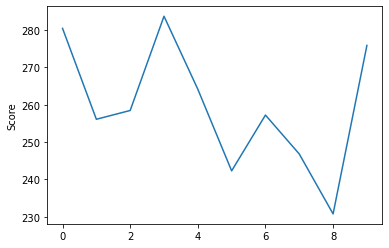

In [13]:
agent = Agent(state_size=8, action_size=4,buffer_size = 100000, batch_size = 128, LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')
test_it(agent,10,render=True,print_out_score=False)

#### A Trained Agent is provided with the ipynb file run the above cells to see the agent in action or below is a video attached of the agent performing the task. 

In [14]:
from IPython.display import Video
Video("LunarLander_trained.mp4",width=720, height=480)

#### We can see by running the above code we get a mean score above 200, which is the solution to our problem statement.

The train function and other plotting and printing functions are declared below.

In [9]:
def plot_status(epsilon_trace, Steps_per_episode_plot, scores, i_episode, Avg_score_per100_episode_plot):
    fig = plt.figure(figsize=(10, 10))

    plt.subplot(3, 3, 1)
    plt.plot(epsilon_trace[:i_episode + 1])
    plt.ylabel('Random Action Probability ($\epsilon$)')
    plt.ylim(0, 1)
    
    plt.subplot(3, 3, 2)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    
    plt.subplot(3, 3, 3)
    plt.plot(Avg_score_per100_episode_plot)
    plt.ylabel('Scores per 100 episode')
    
    plt.subplot(3, 3, 4)
    plt.plot(Steps_per_episode_plot[:i_episode + 1])
    plt.ylabel('Steps per episode in hundreds')
    
    plt.subplot(3, 3, 5)
    plt.plot(Decay_LR)
    plt.ylabel('Learning rate')
    
    plt.tight_layout()
    plt.show()

In [10]:
def print_out_scores(scores,i_episode,scores_window,Steps_per_episode,epsilon_trace,LR_decay, Steps_per_episode_plot,Avg_score_per100_episode_plot):
    if i_episode % 100 == 0 and i_episode != 0:
        temp = np.mean(((Steps_per_episode[i_episode-100:i_episode+1])))
        print('\rEpisode {}\tAverage Score: {:.2f}\tAverage_#Stepsperepisode_last_100_episode: {:.2f}'.format(i_episode, np.mean(scores_window), temp))
        Steps_per_episode_plot.append(temp)
        Avg_score_per100_episode_plot.append(np.mean(scores_window))
        if LR_decay == True : agent.adjust_learning_rate(i_episode)
    if np.mean(scores_window)>=200.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        torch.save(agent.Qnet_local.state_dict(), 'trainedagent.pth')
        plot_status(epsilon_trace, Steps_per_episode_plot, scores, i_episode, Avg_score_per100_episode_plot)
    return Steps_per_episode_plot

In [11]:
def train(n_episodes, max_steps_per_episode, epsilon, final_epsilon, gamma, tau, update_every, batch_size, epsilon_decay,LR_decay,render):

    scores = [] ## Storing scores for every episode
    scores_window = deque(maxlen=100) ## Storing scores for every 100 episodes
    epsilon_trace = np.zeros(n_episodes) ## stores values of epsilon
    Steps_per_episode = np.zeros(n_episodes)## stores steps for every for calculation
    Steps_per_episode_plot = [] ## stores steps for every for plotting
    Avg_score_per100_episode_plot = [] ## Storing number of steps for every 100 episodes easier to understand plot
    for i_episode in range(0, n_episodes):
        state = env.reset()
        score = 0
        for t in range(1,max_steps_per_episode+1):
            if render == True : env.render()
            action = agent.epsilon_greedy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.make_experiences(state, action, reward, next_state, done, gamma, tau, update_every, batch_size)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)
        scores.append(score)
        epsilon = max(final_epsilon, epsilon_decay*epsilon)
        epsilon_trace[i_episode] = epsilon
        Steps_per_episode[i_episode] = t
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        Steps_per_episode_plot = print_out_scores(scores,i_episode,scores_window,Steps_per_episode,epsilon_trace,LR_decay, Steps_per_episode_plot,Avg_score_per100_episode_plot)
        if np.mean(scores_window)>=200.0:
            if render == True : env.close()
            break

#### The hyperparameter search for the below parameters is given at the end

Episode 100	Average Score: -103.39	Average_#Stepsperepisode_last_100_episode: 211.83
Episode 200	Average Score: -12.29	Average_#Stepsperepisode_last_100_episode: 745.80
Episode 300	Average Score: 175.90	Average_#Stepsperepisode_last_100_episode: 515.81
Episode 323	Average Score: 201.17
Environment solved in 223 episodes!	Average Score: 201.17


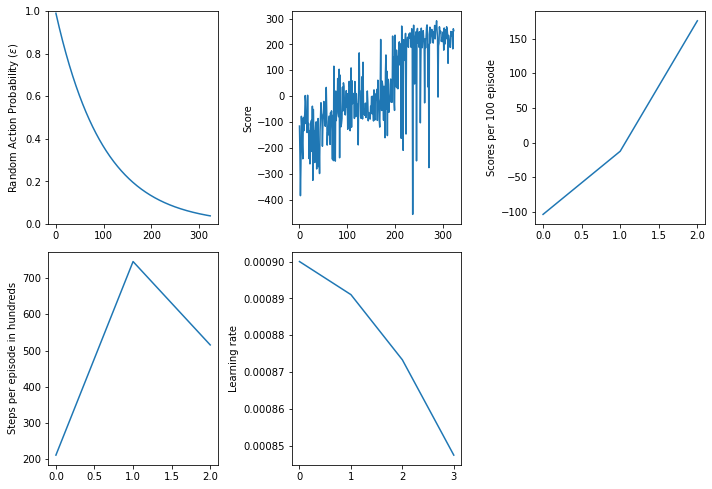

In [12]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 128,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 128, epsilon_decay = 0.99, LR_decay = True, render = False)

### 3. Problems with Online-Q learning - Code

<!-- Now we will see how we arrived at our solution, the difficulties faced during the design of this code, a brief description of the algorithms involved and discussion on the hyperparameter search. -->

Starting with the need for experience replay buffer and a target network for our problem we show the performance of an agent trained without these two elements present

In [12]:
import neuralnetworks_A4 as nn
from IPython.display import display, clear_output

#### Note : We have added a Relu activation function in the NeuralNetworks.py file and will be running the code using it.

Below code is referenced from Lecture 19 "Reinforcement Learning Modular Framework"- CS545 [15]

In [13]:
from abc import ABC, abstractmethod
    
class Environment(ABC):
    
    def __init__(self, valid_actions):
        self.valid_actions = valid_actions

    @abstractmethod
    def initial_state(self):
        return state  # the initial state
    
    @abstractmethod
    def next_state_reinforcement_terminal_state(self, action):
        return next_state, reward, done, info

In [14]:
class Agent_numpy(ABC):
    
    def __init__(self, environment):
        self.environment = environment

    @abstractmethod
    def make_samples(self, n_samples, epsilon):
        return X, R, Qn, terminal_state

    def update_Qn(self, X, Qn, terminal_state):
        n_samples = X.shape[0]
        for i in range(n_samples - 1):
            if not terminal_state[i+1]:
                Qn[i] = self.use(X[i+1])
        return Qn

    def epsilon_greedy(self, state, epsilon):
        valid_actions = self.environment.valid_actions
        if np.random.uniform() < epsilon:
            # Random Move
            action = valid_actions.sample()
            #print('random',action)
        else:
            # Greedy Move
            valid_actions_temp = [0, 1]
            Qs = [self.use(np.hstack((state, a)).reshape((1, -1))) for a in range(len(valid_actions_temp))]
            ai = np.argmax(Qs)
            action = valid_actions_temp[ai]
            #print('greedy',action)
        return action

    @abstractmethod
    def train(self):
        return

    @abstractmethod
    def use(self, X):
        return # Q values for each row of X, each consisting of state and action

In [15]:
class Qnet_numpy(Agent_numpy):

    def __init__(self, environment, hidden_layers, X_means=None, X_stds=None, Q_means=None, Q_stds=None):
        self.environment = environment
        state_size = environment.initial_state().shape[0] # assumes state is an np.array
        valid_actions = environment.valid_actions
        action_size = 1
        self.Qnet = nn.NeuralNetwork(state_size + action_size, hidden_layers, 1)
        if X_means:
            self.Qnet.X_means = np.array(X_means)
            self.Qnet.X_stds = np.array(X_stds)
            self.Qnet.T_means = np.array(Q_means)
            self.Qnet.T_stds = np.array(Q_stds)

    def make_samples(self, n_samples, epsilon,n_trials):
        #print(score)
        state_size = self.environment.initial_state().shape[0]# assumes state is an np.array
        valid_actions = self.environment.valid_actions
        action_size = 1
        X = np.zeros((n_samples, state_size + action_size))
        R = np.zeros((n_samples, 1))
        Qn = np.zeros((n_samples, 1))
        terminal_state = np.zeros((n_samples, 1), dtype=bool)  # All False values ###Doubt
        state = self.environment.initial_state()
        state,rewards,done,info = self.environment.next_state_reinforcement_terminal_state(0)        # Update state, sn from s and a
        action = self.epsilon_greedy(state, epsilon)
# Collect data from n_samples steps
        score = 0
        for step in range(n_samples):
            #environment.render()
            next_state,reward,done,info = self.environment.next_state_reinforcement_terminal_state(action)        # Update state, sn from s and a
            score += reward
            next_action = self.epsilon_greedy(next_state, epsilon)
            X[step, :] = np.hstack((state, action))
            R[step, 0] = reward
            Qn[step, 0] = self.use(np.hstack((next_state, next_action))) ## forward pass
            # Advance one time step
            state, action = next_state, next_action
            if done ==  True:
                break
        Sout.append(score)
        Steps_per_episode.append(step)
        return X, R, Qn, terminal_state

    def train(self, n_trials, n_steps_per_trial, n_epochs, method, learning_rate, 
              gamma, epsilon, final_epsilon, trial_callback):
        
        if trial_callback:
            fig = plt.figure(figsize=(10, 10))
            
        print(n_trials, n_steps_per_trial, n_epochs, method, learning_rate, 
              gamma, epsilon, final_epsilon)
        epsilon_decay =  np.exp(np.log(final_epsilon) / n_trials) # to produce this final value
        print('epsilon_decay is', epsilon_decay)
        epsilon_trace = np.zeros(n_trials)
        r_trace = np.zeros(n_trials)
        for trial in range(n_trials):
            X, R, Qn, terminal_state = self.make_samples(n_steps_per_trial, epsilon, n_trials)
            for epoch in range(n_epochs):
                self.Qnet.train(X, R + gamma * Qn, 1,  method=method, learning_rate=learning_rate, batch_size=None, verbose=False)
                self.update_Qn(X, Qn, terminal_state)

            epsilon *= epsilon_decay
            
            ##plotting
            epsilon_trace[trial] = epsilon
            r_trace[trial] = np.mean(R)

            if trial_callback and (trial + 1 == n_trials or trial % (n_trials / 100) == 0):
                fig.clf()
                trial_callback(agent, trial, n_trials, X, epsilon_trace, r_trace)
                clear_output(wait=True)
                display(fig)

        if trial_callback:
            clear_output(wait=True)
        return epsilon_trace, r_trace

    def use(self, X):
        return self.Qnet.use(X)

In [16]:
class LunarLander(Environment):
    
    def __init__(self,valid_actions):
        super().__init__(valid_actions)
        
    def initial_state(self):
        state = environment.reset()
        return state
    
    def next_state_reinforcement_terminal_state(self,action):
        next_state, reward, done, info = environment.step(action)
        return next_state, reward, done, info

In [17]:
def test_it_numpy(agent, n_trials):
    for i_episode in range(n_trials):
        observation = environment.reset()#state initailized to a random point
        done = False## information on terminal state
        score = 0#initializing reward
        while not done:
            environment.render()
            a = agent.epsilon_greedy(observation, 0.0) # epsilon = 0
            obs,rew,done,info = agent.environment.next_state_reinforcement_terminal_state(a)
            score+=rew
        print('Episode:{} Score:{}'.format(i_episode, score))
    environment.close()

In [18]:
def plot_status_numpy(agent, trial, n_trials, X, epsilon_trace, r_trace):

    plt.subplot(3, 3, 1)
    plt.plot(epsilon_trace[:trial + 1])
    plt.ylabel('Random Action Probability ($\epsilon$)')
    plt.ylim(0, 1)
               
    plt.subplot(3, 3, 2)
    plt.plot(r_trace[:trial + 1], alpha=0.5)
    plt.ylabel('Mean reinforcement')
    
    plt.subplot(3, 3, 3)
    plt.plot(Sout, alpha=0.5)
    plt.ylabel('Score')
    
    plt.subplot(3, 3, 4)
    plt.plot(Steps_per_episode, alpha=0.5)
    plt.ylabel('Steps per episode')
    
    plt.tight_layout()

Episode:0 Score:-142.57645852489793
Episode:1 Score:-464.32127280710813
Episode:2 Score:-143.77250222718254
Episode:3 Score:-127.52208560227055
Episode:4 Score:-391.56787643311407
Episode:5 Score:-148.75540566452372
Episode:6 Score:-39.742163803248474
Episode:7 Score:-107.54434085442944
Episode:8 Score:-89.0644027298525
Episode:9 Score:-502.95281486447834


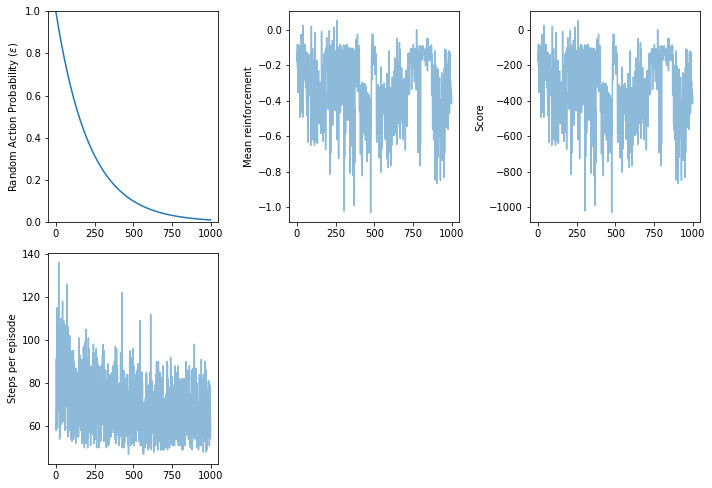

In [19]:
environment = gym.make('LunarLander-v2')
Sout = []
Steps_per_episode = []
global Sout,Steps_per_episode
LL = LunarLander(valid_actions=environment.action_space)
agent = Qnet_numpy(LL, hidden_layers=[64,64],
             X_means=[0, 0, 0, 0, 0, 0, 0, 0, 1.5], X_stds=[1, 1, 1, 1, 1, 1, 1, 1, 1],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=1000, n_steps_per_trial=1000, n_epochs=100,
                                      method='adam', learning_rate=0.0005, gamma=0.9999,
                                      epsilon=1, final_epsilon=0.01,trial_callback=plot_status_numpy)
#environment.close()
test_it_numpy(agent, 10)

We can see that we don't get the desired results, this is due to the complexity of the environment we are dealing with.
The method of learning used here is known as Online-Q as mentioned in "A Deeper Look at Experience Replay" by Shangtong Zhang, Richard S. Sutton 2018 [2], where no experience replay is used. The agent learns from each transition once and discards it immediately after.

### 4. Brief description of the Algorithms introduced to overcome the problems associated with Online-Q

#### Now we'll look at the  Q-learning algorithm

Q-learning is an off policy reinforcement learning algorithm that seeks to find the best action to take given the current state. It’s considered off-policy because the q-learning function learns from actions that are outside the current policy, like taking random actions, and therefore a policy isn’t needed. More specifically, q-learning seeks to learn a policy that maximizes the total reward.[11] below figure[12] represents the above statement mathematically for task with final states and not dealing with infinite sums. 

We will explain Q network in a bit more detail when explaining the need for a target network below.

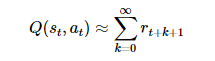

#### Definition of Experience Learning - From Self-improving reactive agents based on reinforcement learning, planning and teaching (Lin, 1992) [10]

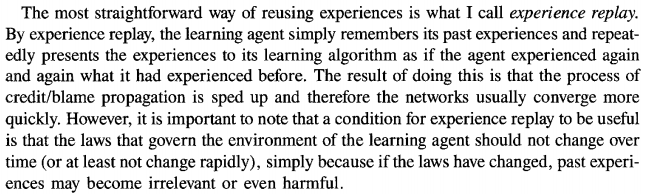

Now we we'll give a short explanation of the Online-Q method used above

Online-Q is the online Q-learning algorithm, where no experience replay is used. The agent learns from each transition once and discards it immediately after.
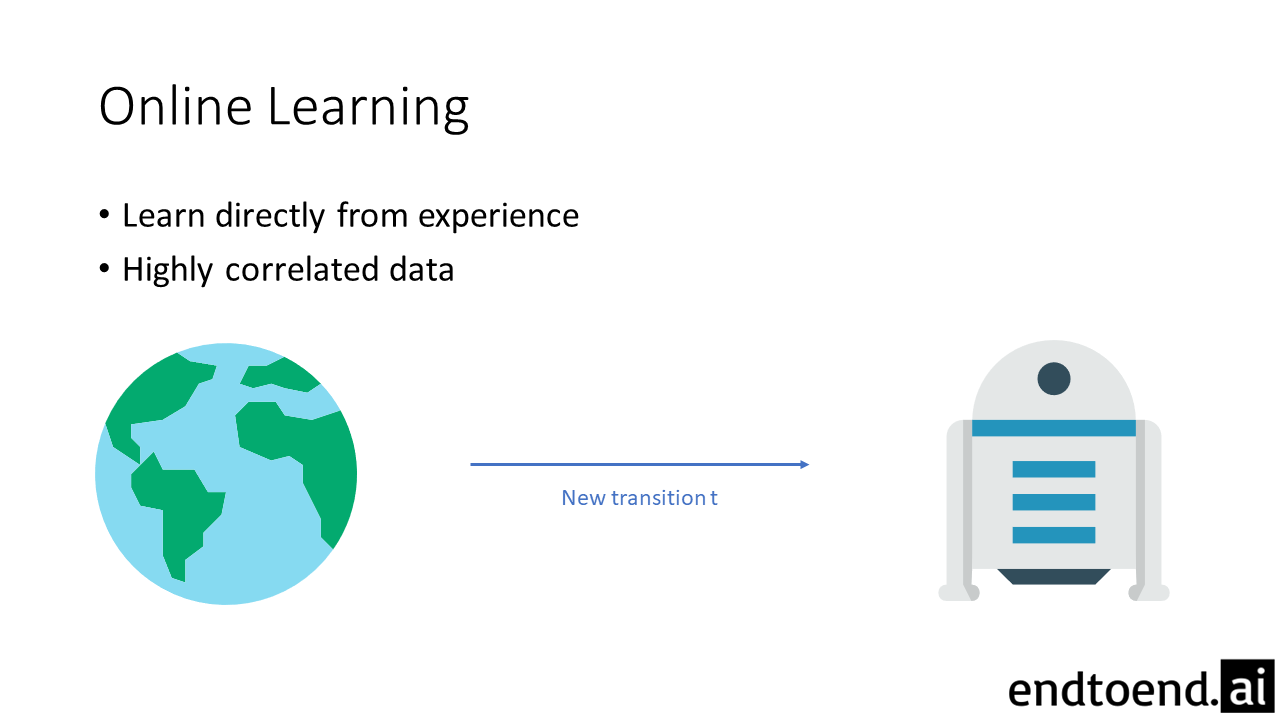

Now we'll take a good look at Buffer-Q as mentioned in the same paper mentioned above, where Buffer-Q is Q-learning with experience replay. Every transition is stored into the replay buffer D. The agent learns by sampling a batch B
from this buffer.

Below figure describes the Experience Replay buffer, the problem is that the size of the buffer is plays a crucial role in the performance of the agent and varies form task to task, If the replay buffer is too small, the replay buffer serves little to no purpose. If the replay buffer is too big, the batched samples are uncorrelated, but the agent will learn from the newest experience a long time after, but a general rule of thumb has been adopted to consider the buffer size as 100000, which is used in most of the papers using DQN, Hindsight Experience Replay, Prioritized Experience Replay or DDPG. [7]

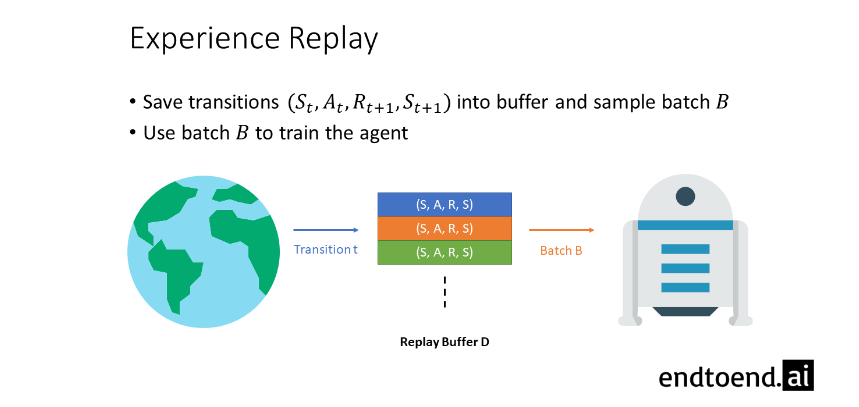

Below we give the DQN algorithm with an experience replay buffer as described in "Playing Atari with Deep Reinforcement Learning" - Mnih et al 2013 [1]

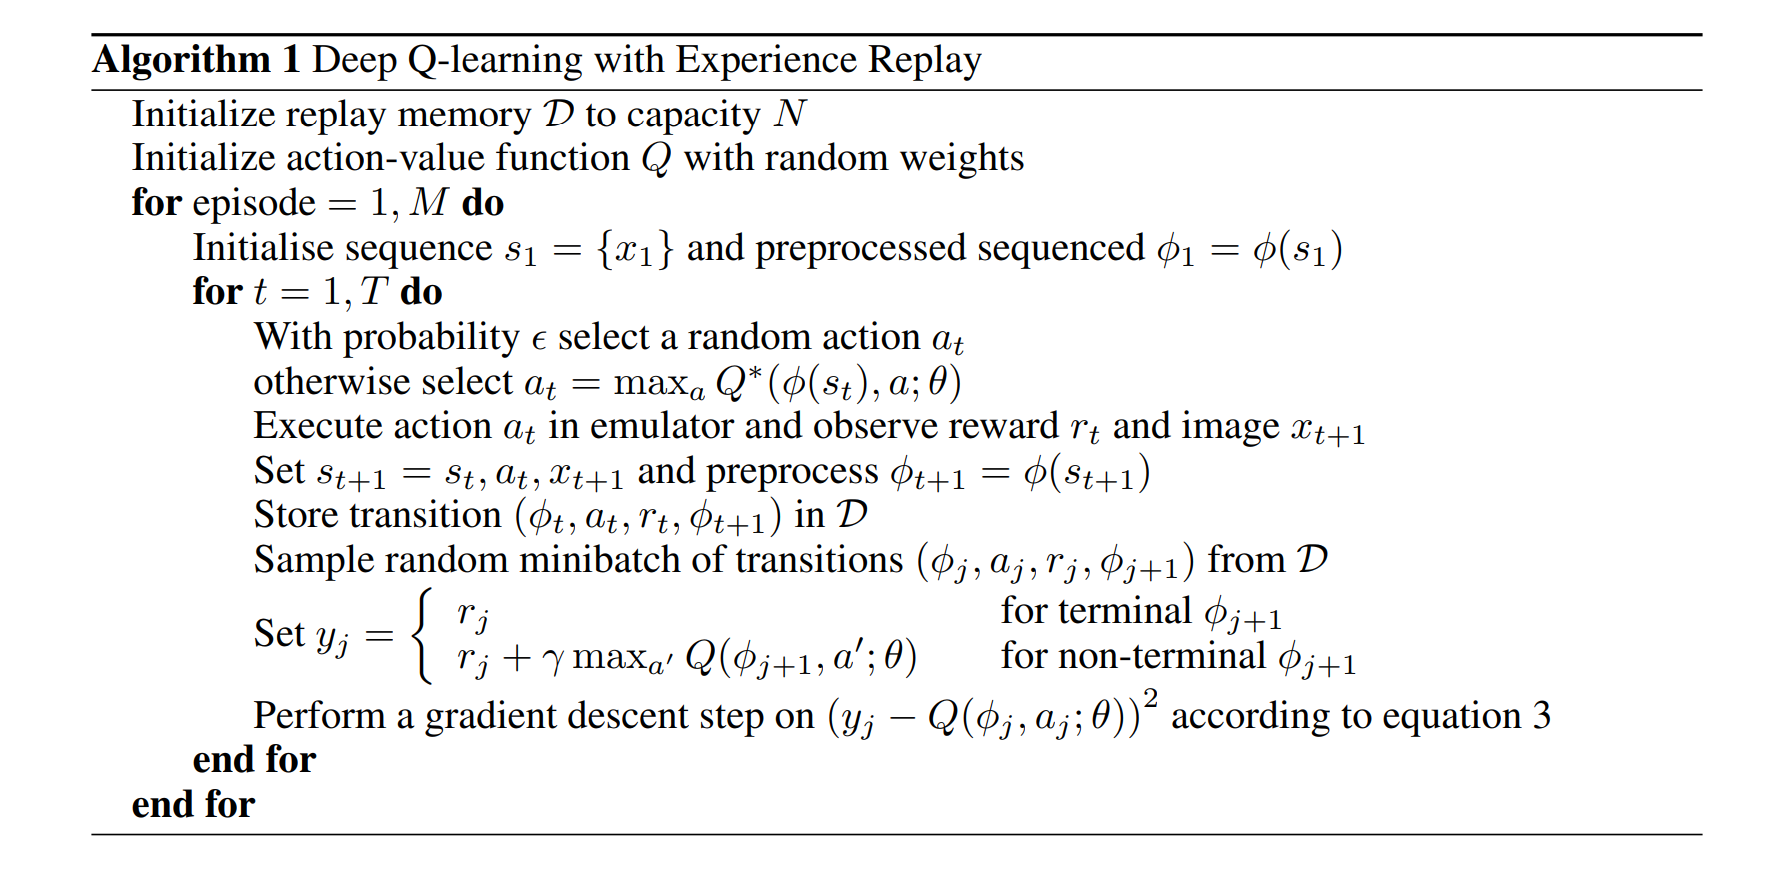

Below we give the algorithm as described in ""Continuous control with deep reinforcement learning" - by Timothy P. Lillicrap et. al. 2019[8], where the idea of target network with soft update is introduced in the DDPG algorithm
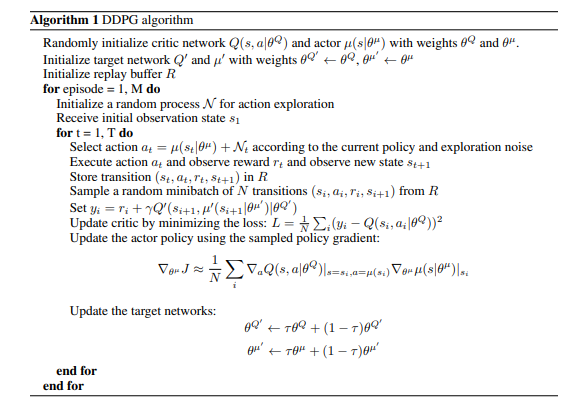

#### Why the need for a target network?

Q-Learning updates the Q-value as follows.

Q(s,a)=Q(s,a)+α(R+γmaxQ(s′,a′)−Q(s,a))

Where α is the learning rate. In the update equation, Q(s,a) is updated by multiplying R+γmaxQ(s′,a′)−Q(s,a) by α. If α=0, Q(s,a) will not change, and if α=1, Q(s,a) will beR+γmaxQ(s′,a′). Since α is usually between 0.0 and 1.0, you can think of this update expression as:

Q(s,a)=Q(s,a)+α(R+γmaxQ(s′,a′)−Q(s,a))

where R+γmaxQ(s′,a′) is the Target calculated using the Bellman equation

Q(s,a)→R+γmaxQ(s′,a′)

That is, when learning continues, Q(s,a) approaches R+γmaxQ(s′,a′). If we denote the weight and bias of Q-network as θ, we can use the above equation as follows.

Q(s,a;θ)→R+γmaxQ(s′,a′;θ)

The problem with this equation is that the current value and the goal use the same network weight. The weight of the Q-network changes with each learning. However, since the goal also changes, it may be difficult to converge to a certain value. Therefore, a separate network with the same structure as the Q-network named target network is created and marked with the symbol θ'.

Q(s,a;θ)→R+γmaxQ(s′,a′;θ')

The target network maintains a fixed value during the learning process of the original Q-network, and then periodically resets it to the original Q-network value. This can be effective learning because the Q-network can be approached with a fixed target network. [13]

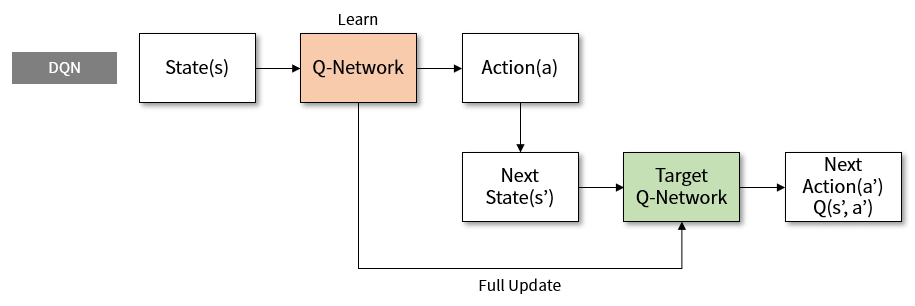

A soft update means that we do not update this target network at once, but frequently and very little. The value of τau is used. In Deepmind’s paper -"Continuous control with deep reinforcement learning" - by Timothy P. Lillicrap et. al. 2019[8], which proposed an algorithm called DDPG, they used τau=0.001. The target network is updated as follows.

θ' = θ × τau + θ' × (1−τau)

The target network will move slightly to the value of Q-network. Since the value of τau is small, the update should be frequent so that the effect will be noticeable. [13]
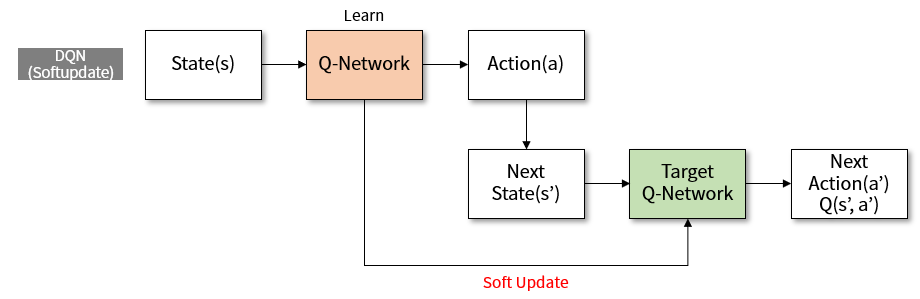

<!-- Below we give the algorithm as described in "Playing Atari with Deep Reinforcement Learning" - Mnih et al 2013 [1] and add the target network into it [8] -->

<!-- ![DDQN_ER.PNG](attachment:DDQN_ER.PNG) -->

#### In the below diagram[6] we descirbe the DQN algorithm with Experience Replay Buffer and Target Network [6]

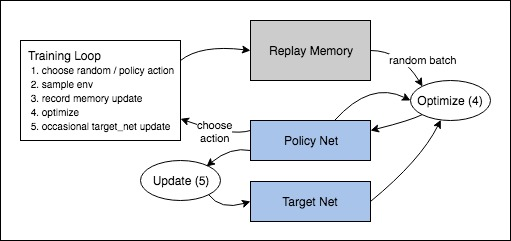

#### Decaying learning rate
An Extra component is added in this algorithm in the form of a exponentially deacying learning rate so as to avoid starting with a very low value for learning rate which helps in both optimization and generalization.

With a constant learning rate, the steps taken by our algorithm while iterating towards minima are so noisy that after certain iterations it seems wandering around the minima and do not actually converges.

The learning rate is large initially we still have relatively fast learning but as tending towards minima learning rate gets smaller and smaller, end up oscillating in a tighter region around minima rather than wandering far away from it. [9]

#### From the above figure the algorithm implemented in this project can be simply written as:
1. Initialize local and target network.
2. Initialize experience replay buffer.
3. Initialize environment
4. Check if environment is Solved - For loop
5. Check if condition is True for decaying learning rate : if True then decay learning rate.
6. Selecting action an randomly or argmax depending on epsilon value.
7. Pass selected action into the environment
8. Record experiences generated into memory.
9. Check if enough sample experiences are available in memory to learn.
10. If enough samples are available then select a batch of samples at random from the experience memory. 
11. Calculate loss based on Q value of target network using the bellman equation and expected Q value using the local network and then optimize it, here the local network gets updated.
12. Update target network weights by copying weights from local network based on the value of Tau

### 5. Hyperparameter search for DQN agent with Experience replay

#### Below we will start our hyperparameter search to find the best value for each of the variable

Before that we we'll describe our hyperparameters here:
1. Loss Function - Calculates the difference between expected target value and actual target value : 
   1. Huber_Loss
   2. MSE_Loss
   
   
2. Learning rate - Controls how much to change the model in response to the estimated error each time the model weights are   updated , we are employing a decaying learning rate here so as better control the learning process.


3. Gamma - Is the discount factor, it is used to define how you value your future rewards. A value closer to 1 gives a very   high importance on future rewards, this is useful for when there are huge rewards associated with final states of a            task.


4. Epsilon decay - This is the exploration factor, it is at the crux of the exploration vs exploitation problem.


5. Buffer Size - This factor influences the performance of the agent, a larger value will mean probability of sampling of uncorrelated data is high which is good but slows down training, a lower value on the other hand mean correlation between sampled data will be high so model wont be trained effectively.


6. Batch_Size - Represents the size of the sample data selected from the experience replay buffer for the neural network to be trained on.


7. Tau - Defines how much the target network is updated


Note : 
1.  The activation function is selected as randomized leaky relu on its comparison with relu and leaky_relu and was found to be            working better

2.  The Structure of the hidden layer is set [128,128] found using experimentation which has not been shown below


#### Starting with the Loss function

Hidden_layer = [128 128] two hidden layers with 128 neurons each 

1. Loss Function : Mean Square Error

Episode 100	Average Score: -150.67	Average_#Stepsperepisode_last_100_episode: 165.18
Episode 200	Average Score: -123.53	Average_#Stepsperepisode_last_100_episode: 603.98
Episode 300	Average Score: -60.27	Average_#Stepsperepisode_last_100_episode: 855.93
Episode 400	Average Score: -61.87	Average_#Stepsperepisode_last_100_episode: 728.11
Episode 500	Average Score: 2.29	Average_#Stepsperepisode_last_100_episode: 557.34
Episode 600	Average Score: 151.59	Average_#Stepsperepisode_last_100_episode: 500.24
Episode 652	Average Score: 202.67
Environment solved in 552 episodes!	Average Score: 202.67


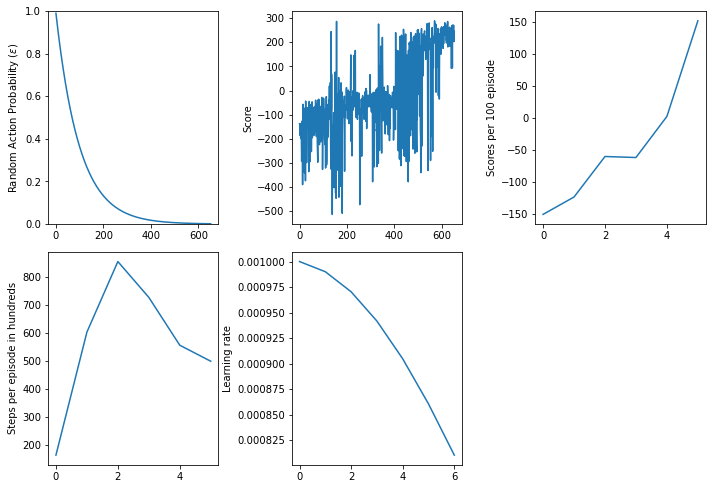

In [13]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 64,
              LR = 0.001,LR_decay_rate = 0.01, Error_Type = 'mse_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.999, tau = 0.001, batch_size = 64, epsilon_decay = 0.99, LR_decay = True)

1. Loss Function : Huber loss 

This loss combines advantages of both L1Loss and MSELoss; the delta-scaled L1 region makes the loss less sensitive to outliers than MSELoss, while the L2 region provides smoothness over L1Loss near 0.[14]
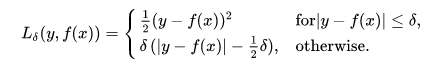

Episode 100	Average Score: -99.67	Average_#Stepsperepisode_last_100_episode: 169.32
Episode 200	Average Score: -5.44	Average_#Stepsperepisode_last_100_episode: 759.66
Episode 300	Average Score: 124.90	Average_#Stepsperepisode_last_100_episode: 543.03
Episode 400	Average Score: 132.08	Average_#Stepsperepisode_last_100_episode: 467.12
Episode 475	Average Score: 201.87
Environment solved in 375 episodes!	Average Score: 201.87


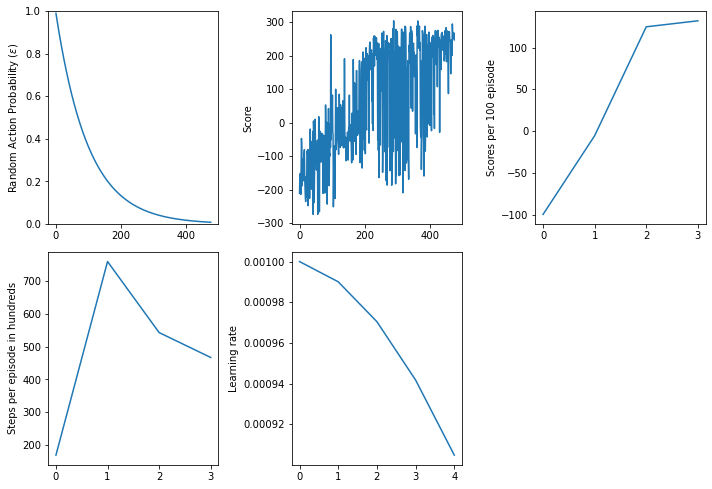

In [16]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 64,
              LR = 0.001,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.999, tau = 0.001, batch_size = 64, epsilon_decay = 0.99, LR_decay = True)

#### Conclusion :
1. We can clearly see that Huber loss outperforms Mean square error loss by high margin.
2. With MSE_Loss we can see that there is a region from episode 200 to episode 400 where there is no growth on average in scores.
3. With Huber loss we see a steady rise in average scores.
4. With both the error methods we can see that the number of steps decrease after the agent has learned to land on the target so as to optimize and increase its reward.
5. We'll be using huber_loss going forward from here

#### Constant Learning rate

Episode 100	Average Score: -124.45	Average_#Stepsperepisode_last_100_episode: 185.90
Episode 200	Average Score: -45.01	Average_#Stepsperepisode_last_100_episode: 776.07
Episode 300	Average Score: 81.93	Average_#Stepsperepisode_last_100_episode: 728.35
Episode 400	Average Score: 193.08	Average_#Stepsperepisode_last_100_episode: 389.56
Episode 410	Average Score: 200.33
Environment solved in 310 episodes!	Average Score: 200.33


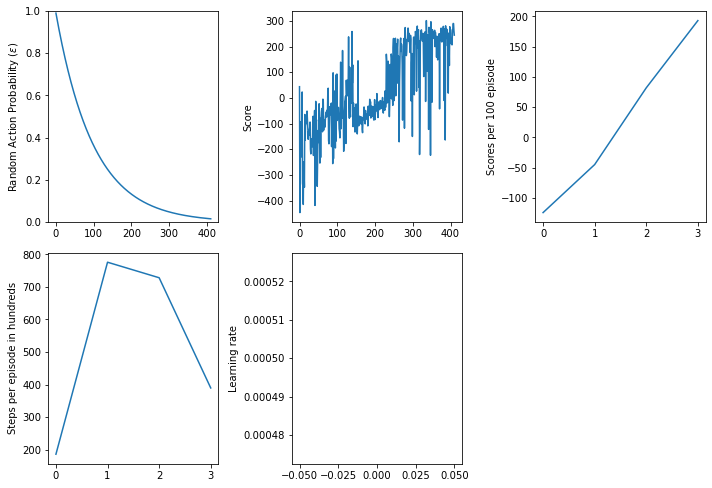

In [15]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 64,
              LR = 0.0005,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.999, tau = 0.001, batch_size = 64, epsilon_decay = 0.99, LR_decay = False)

#### Decaying Learning Rate

Episode 100	Average Score: -80.46	Average_#Stepsperepisode_last_100_episode: 228.56
Episode 200	Average Score: 1.69	Average_#Stepsperepisode_last_100_episode: 764.81
Episode 300	Average Score: 177.10	Average_#Stepsperepisode_last_100_episode: 484.55
Episode 334	Average Score: 200.42
Environment solved in 234 episodes!	Average Score: 200.42


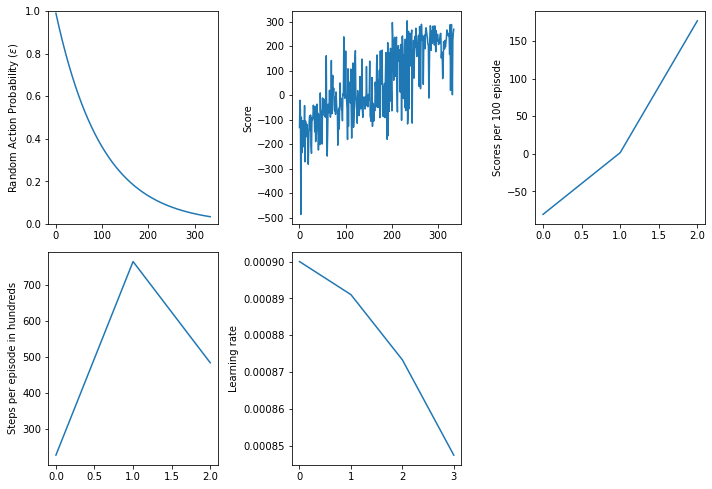

In [22]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 64,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.999, tau = 0.001, batch_size = 64, epsilon_decay = 0.99, LR_decay = True)

#### Conclusion:
1. We can see that with a low constant learning rate we get better performance when compared with the huber loss experiment.
2. But with an exponentially decaying learning rate we get a much better performance when compared with constant learning rate.
3. With the constant learning rate we can see the flat region in where the score remains almost constant and does not improve much.
4. With the exponentially decaying learning rate we get a positive slope for scores per episode, and it is evident from the scores plot that the agent does not get stuck in local minima.
5. We'll be moving forward with a decaying learning rate.

#### Gamma - Discount Factor :
Here we will explore three values for the gamma factor and compare the agents performance
1. gamma = 0.9
2. gamma = 0.99
3. gamma = 0.995
4. gamma = 0.9999

A higher value of gamma is suitable for a longer problem horizon
So to calculate the value by which you would be discounting the reward is given by : 
(gamma)^Number of steps into future we care about with respect to a task
so for our case lets assume it to be 200 steps then we get

1. discounting value = 0.9^200 = 0.0000000007
2. discounting value = 0.99^200 = 0.134
3. discounting value = 0.995^200 = 0.366
4. discounting value = 0.9999^200 = 0.98

In [24]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 64,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9, tau = 0.001, batch_size = 64, epsilon_decay = 0.99, LR_decay = True)

Episode 100	Average Score: -115.46	Average_#Stepsperepisode_last_100_episode: 179.69
Episode 200	Average Score: -45.82	Average_#Stepsperepisode_last_100_episode: 646.71
Episode 300	Average Score: -102.16	Average_#Stepsperepisode_last_100_episode: 881.68
Episode 400	Average Score: -98.63	Average_#Stepsperepisode_last_100_episode: 820.59
Episode 500	Average Score: -101.37	Average_#Stepsperepisode_last_100_episode: 890.97
Episode 600	Average Score: -93.19	Average_#Stepsperepisode_last_100_episode: 812.25
Episode 700	Average Score: -118.18	Average_#Stepsperepisode_last_100_episode: 608.98
Episode 800	Average Score: -119.57	Average_#Stepsperepisode_last_100_episode: 691.78
Episode 900	Average Score: -123.12	Average_#Stepsperepisode_last_100_episode: 657.71
Episode 1000	Average Score: -124.69	Average_#Stepsperepisode_last_100_episode: 547.36
Episode 1100	Average Score: -119.10	Average_#Stepsperepisode_last_100_episode: 508.56
Episode 1200	Average Score: -118.17	Average_#Stepsperepisode_last_

Episode 100	Average Score: -115.79	Average_#Stepsperepisode_last_100_episode: 163.56
Episode 200	Average Score: -27.73	Average_#Stepsperepisode_last_100_episode: 734.93
Episode 300	Average Score: 158.27	Average_#Stepsperepisode_last_100_episode: 639.86
Episode 400	Average Score: 182.29	Average_#Stepsperepisode_last_100_episode: 486.01
Episode 500	Average Score: 196.03	Average_#Stepsperepisode_last_100_episode: 512.40
Episode 509	Average Score: 200.23
Environment solved in 409 episodes!	Average Score: 200.23


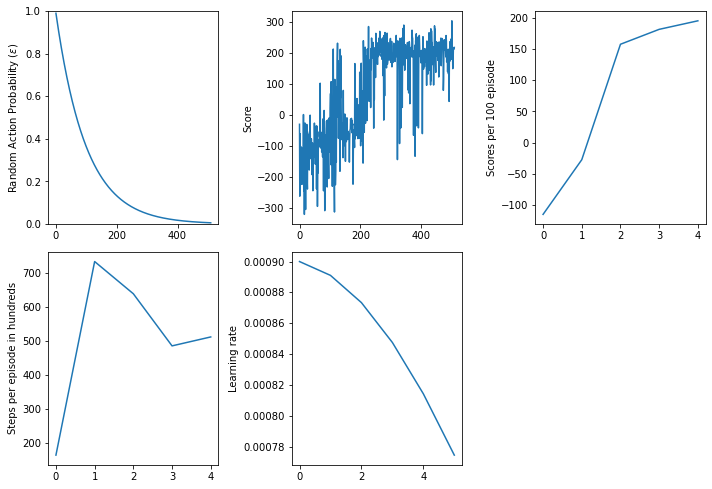

In [25]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 64,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.99, tau = 0.001, batch_size = 64, epsilon_decay = 0.99, LR_decay = True)

Episode 100	Average Score: -94.06	Average_#Stepsperepisode_last_100_episode: 202.35
Episode 200	Average Score: -45.81	Average_#Stepsperepisode_last_100_episode: 722.75
Episode 300	Average Score: 104.82	Average_#Stepsperepisode_last_100_episode: 674.86
Episode 400	Average Score: 172.25	Average_#Stepsperepisode_last_100_episode: 467.52
Episode 482	Average Score: 201.89
Environment solved in 382 episodes!	Average Score: 201.89


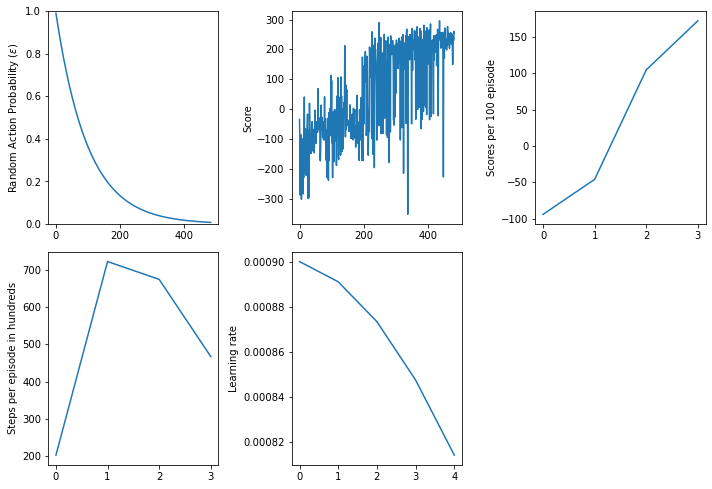

In [27]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 64,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.995, tau = 0.001, batch_size = 64, epsilon_decay = 0.99, LR_decay = True)

Episode 100	Average Score: -103.99	Average_#Stepsperepisode_last_100_episode: 164.64
Episode 200	Average Score: -53.47	Average_#Stepsperepisode_last_100_episode: 657.31
Episode 300	Average Score: 129.37	Average_#Stepsperepisode_last_100_episode: 661.67
Episode 369	Average Score: 200.25
Environment solved in 269 episodes!	Average Score: 200.25


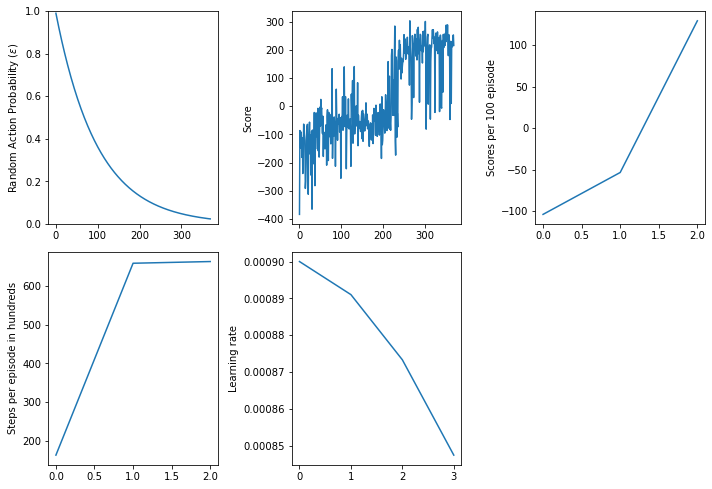

In [30]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 64,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9994, tau = 0.001, batch_size = 64, epsilon_decay = 0.99, LR_decay = True)

Episode 100	Average Score: -101.21	Average_#Stepsperepisode_last_100_episode: 203.19
Episode 200	Average Score: -16.06	Average_#Stepsperepisode_last_100_episode: 705.80
Episode 300	Average Score: 188.85	Average_#Stepsperepisode_last_100_episode: 527.88
Episode 316	Average Score: 201.83
Environment solved in 216 episodes!	Average Score: 201.83


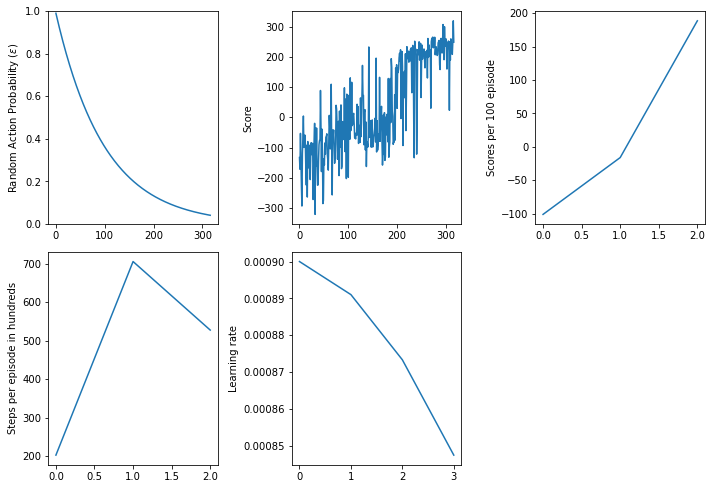

In [31]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 64,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 64, epsilon_decay = 0.99, LR_decay = True)

#### Conclusion:
1. We can say that as the discount factor increases the performance increases but only upto a certain point after which there is no significant increase in performance with increase in discount factor.
2. We will be using gamma = 0.9999 going forward.

#### Epsilon decay

Episode 100	Average Score: -114.20	Average_#Stepsperepisode_last_100_episode: 151.82
Episode 200	Average Score: -6.03	Average_#Stepsperepisode_last_100_episode: 645.03
Episode 300	Average Score: 127.08	Average_#Stepsperepisode_last_100_episode: 589.98
Episode 394	Average Score: 200.94
Environment solved in 294 episodes!	Average Score: 200.94


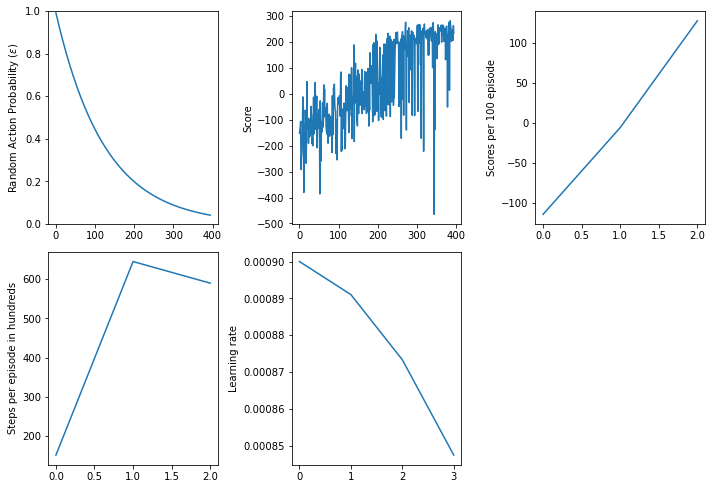

In [36]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 64,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 64, epsilon_decay = 0.992, LR_decay = True)

Episode 100	Average Score: -40.09	Average_#Stepsperepisode_last_100_episode: 515.61
Episode 200	Average Score: -14.26	Average_#Stepsperepisode_last_100_episode: 779.23
Episode 300	Average Score: 105.25	Average_#Stepsperepisode_last_100_episode: 603.14
Episode 400	Average Score: 195.34	Average_#Stepsperepisode_last_100_episode: 512.39
Episode 404	Average Score: 200.29
Environment solved in 304 episodes!	Average Score: 200.29


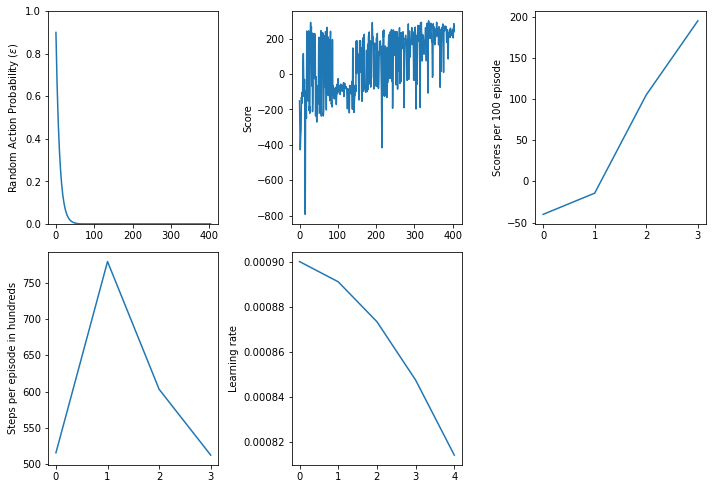

In [38]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 64,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 64, epsilon_decay = 0.9, LR_decay = True)

Episode 100	Average Score: -63.56	Average_#Stepsperepisode_last_100_episode: 538.95
Episode 200	Average Score: 10.94	Average_#Stepsperepisode_last_100_episode: 712.90
Episode 300	Average Score: 80.09	Average_#Stepsperepisode_last_100_episode: 669.94
Episode 400	Average Score: 196.54	Average_#Stepsperepisode_last_100_episode: 416.55
Episode 417	Average Score: 200.51
Environment solved in 317 episodes!	Average Score: 200.51


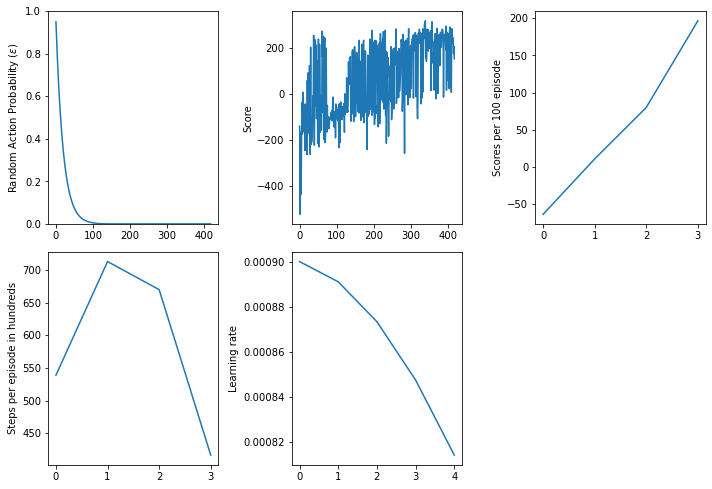

In [39]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 64,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 64, epsilon_decay = 0.95, LR_decay = True)

#### Conclusion:
1. We can see that as we lower the value of epsilon decay the exploration decreases and exploitation increases, which increases the number of steps required to solve the problem, which states that it found a local minima and not a global minima since in our previous experimentations we get the solution with fairly lower number of steps.
2. A higher value of epsilon decay does get the performance going up but there is an upper limit above which there is no significant improvement in performance. 
3. We'll be using epsilon decay = 0.99 from here on, since it gives better performance the above tried values.

#### Buffer Size
1. Buffer size = 1000
2. Buffer size = 50000
3. Buffer size = 250000
4. Buffer size = 500000
5. Buffer size = 1000000

Episode 100	Average Score: -113.27	Average_#Stepsperepisode_last_100_episode: 174.56
Episode 200	Average Score: -44.74	Average_#Stepsperepisode_last_100_episode: 507.45
Episode 300	Average Score: 26.89	Average_#Stepsperepisode_last_100_episode: 429.01
Episode 400	Average Score: 89.66	Average_#Stepsperepisode_last_100_episode: 330.87
Episode 500	Average Score: 86.24	Average_#Stepsperepisode_last_100_episode: 234.34
Episode 600	Average Score: 136.05	Average_#Stepsperepisode_last_100_episode: 289.16
Episode 700	Average Score: 147.08	Average_#Stepsperepisode_last_100_episode: 231.99
Episode 800	Average Score: 100.22	Average_#Stepsperepisode_last_100_episode: 173.32
Episode 900	Average Score: 29.77	Average_#Stepsperepisode_last_100_episode: 162.29
Episode 1000	Average Score: 79.62	Average_#Stepsperepisode_last_100_episode: 146.48
Episode 1100	Average Score: 57.60	Average_#Stepsperepisode_last_100_episode: 139.86
Episode 1200	Average Score: 92.79	Average_#Stepsperepisode_last_100_episode: 15

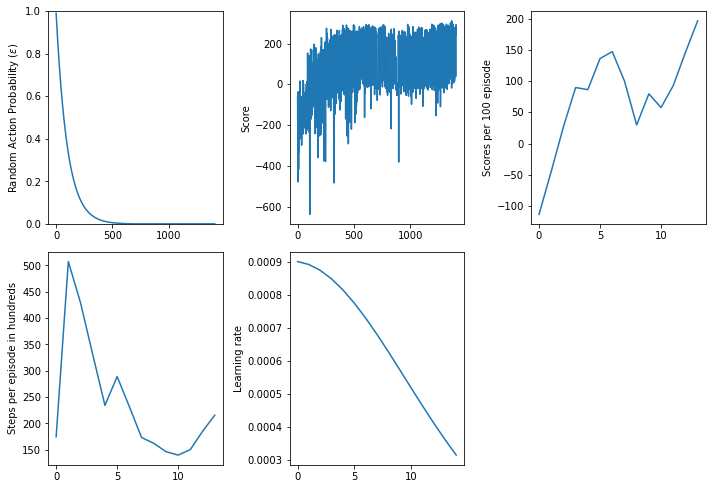

In [42]:
agent = Agent(state_size=8, action_size=4, buffer_size = 1000, batch_size = 64,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 64, epsilon_decay = 0.99, LR_decay = True)

Episode 100	Average Score: -111.50	Average_#Stepsperepisode_last_100_episode: 197.27
Episode 200	Average Score: -23.91	Average_#Stepsperepisode_last_100_episode: 704.66
Episode 300	Average Score: 137.30	Average_#Stepsperepisode_last_100_episode: 516.57
Episode 400	Average Score: 182.94	Average_#Stepsperepisode_last_100_episode: 420.84
Episode 500	Average Score: 192.83	Average_#Stepsperepisode_last_100_episode: 349.36
Episode 510	Average Score: 200.34
Environment solved in 410 episodes!	Average Score: 200.34


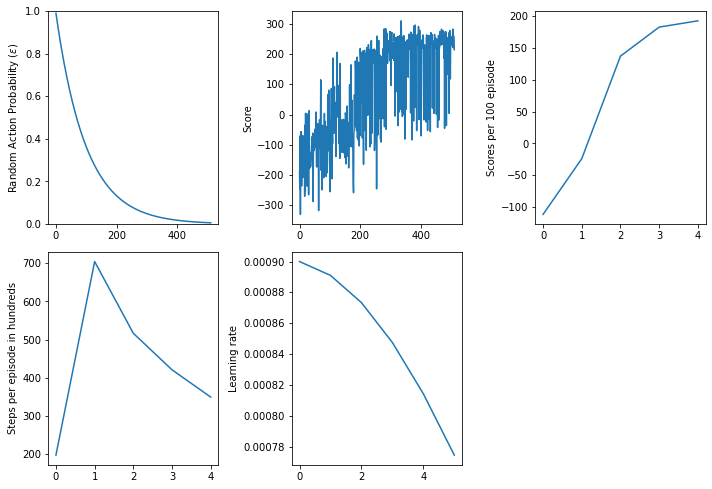

In [40]:
agent = Agent(state_size=8, action_size=4, buffer_size = 50000, batch_size = 64,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 64, epsilon_decay = 0.99, LR_decay = True)

#### Increasing Buffer size

Episode 100	Average Score: -108.00	Average_#Stepsperepisode_last_100_episode: 175.26
Episode 200	Average Score: -34.57	Average_#Stepsperepisode_last_100_episode: 675.61
Episode 300	Average Score: 147.55	Average_#Stepsperepisode_last_100_episode: 560.04
Episode 366	Average Score: 201.49
Environment solved in 266 episodes!	Average Score: 201.49


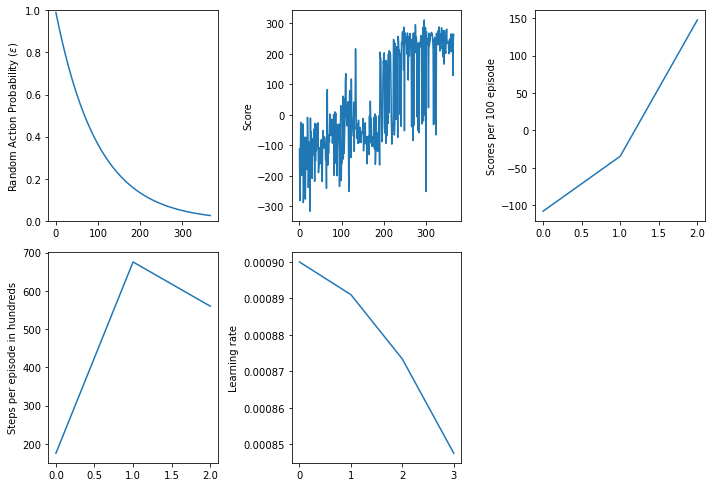

In [44]:
agent = Agent(state_size=8, action_size=4, buffer_size = 250000, batch_size = 64,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 64, epsilon_decay = 0.99, LR_decay = True)

Episode 100	Average Score: -109.67	Average_#Stepsperepisode_last_100_episode: 201.95
Episode 200	Average Score: -29.19	Average_#Stepsperepisode_last_100_episode: 701.53
Episode 300	Average Score: 131.28	Average_#Stepsperepisode_last_100_episode: 591.07
Episode 400	Average Score: 195.37	Average_#Stepsperepisode_last_100_episode: 474.74
Episode 435	Average Score: 200.29
Environment solved in 335 episodes!	Average Score: 200.29


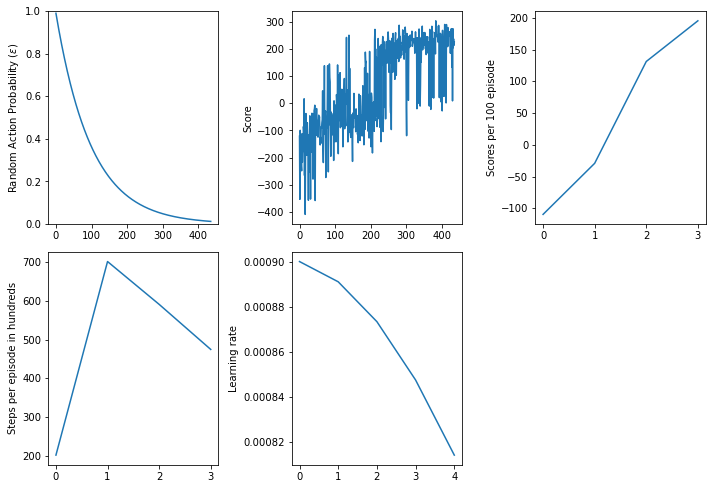

In [43]:
agent = Agent(state_size=8, action_size=4, buffer_size = 500000, batch_size = 64,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 64, epsilon_decay = 0.99, LR_decay = True)

Episode 100	Average Score: -89.81	Average_#Stepsperepisode_last_100_episode: 198.77
Episode 200	Average Score: -27.89	Average_#Stepsperepisode_last_100_episode: 824.47
Episode 300	Average Score: 80.00	Average_#Stepsperepisode_last_100_episode: 716.21
Episode 400	Average Score: 172.80	Average_#Stepsperepisode_last_100_episode: 463.16
Episode 450	Average Score: 200.15
Environment solved in 350 episodes!	Average Score: 200.15


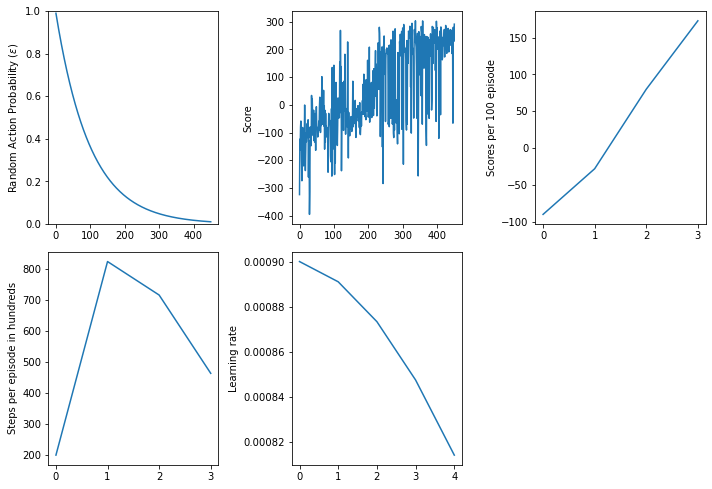

In [46]:
agent = Agent(state_size=8, action_size=4, buffer_size = 1000000, batch_size = 64,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 64, epsilon_decay = 0.99, LR_decay = True)

#### Conclusion:
1. We see that as the size of buffer decreases the agent is unable to learn quickly, since the samples selected from the experience replay buffer do not contain older experiences.
2. Now as the buffer size increases we see that the performance increases but only till a particular upper limit value after which the performance slows down.
3. So in comparison our previous value of buffer size of 100000 gives good results
4. We note here that finding a value for the buffer size is difficult problem, which is why other methods of bypassing this problem must be investigated.
5. We will be using buffer_size = 100000 since it gives the best results observed.

#### Batch size
1. Batch_size = 32
2. Batch_size = 64
3. Batch_size = 128
4. Batch_size = 256

Episode 100	Average Score: -88.05	Average_#Stepsperepisode_last_100_episode: 217.63
Episode 200	Average Score: -8.21	Average_#Stepsperepisode_last_100_episode: 737.04
Episode 300	Average Score: 91.74	Average_#Stepsperepisode_last_100_episode: 556.37
Episode 400	Average Score: 147.95	Average_#Stepsperepisode_last_100_episode: 398.68
Episode 500	Average Score: 139.91	Average_#Stepsperepisode_last_100_episode: 359.22
Episode 600	Average Score: 152.91	Average_#Stepsperepisode_last_100_episode: 276.87
Episode 700	Average Score: 188.13	Average_#Stepsperepisode_last_100_episode: 320.72
Episode 728	Average Score: 200.76
Environment solved in 628 episodes!	Average Score: 200.76


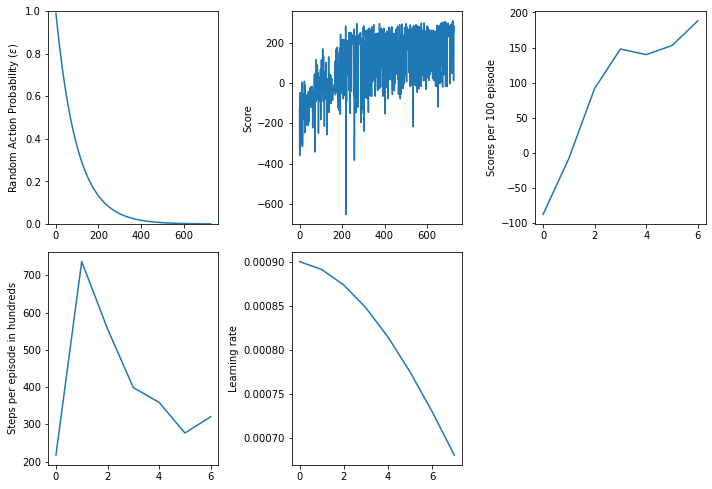

In [58]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 32,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 32, epsilon_decay = 0.99, LR_decay = True)

Episode 100	Average Score: -118.92	Average_#Stepsperepisode_last_100_episode: 189.73
Episode 200	Average Score: -27.94	Average_#Stepsperepisode_last_100_episode: 718.98
Episode 300	Average Score: 133.46	Average_#Stepsperepisode_last_100_episode: 529.30
Episode 400	Average Score: 191.52	Average_#Stepsperepisode_last_100_episode: 415.99
Episode 453	Average Score: 200.10
Environment solved in 353 episodes!	Average Score: 200.10


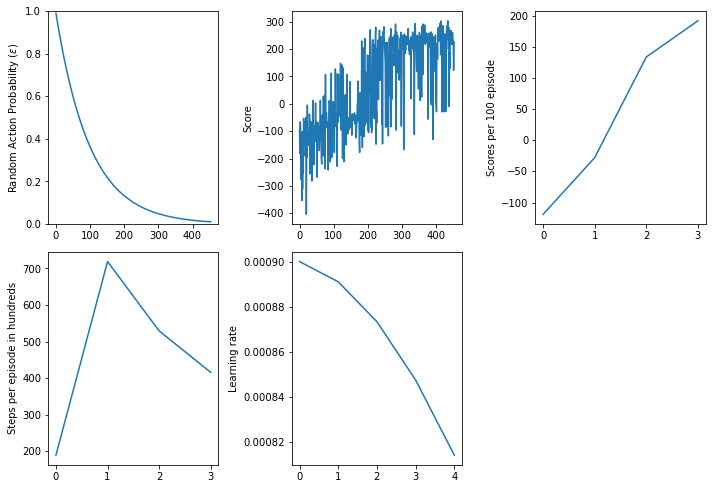

In [63]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 64,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 64, epsilon_decay = 0.99, LR_decay = True)

Episode 100	Average Score: -107.97	Average_#Stepsperepisode_last_100_episode: 192.18
Episode 200	Average Score: -10.31	Average_#Stepsperepisode_last_100_episode: 769.31
Episode 300	Average Score: 172.39	Average_#Stepsperepisode_last_100_episode: 507.60
Episode 322	Average Score: 200.09
Environment solved in 222 episodes!	Average Score: 200.09


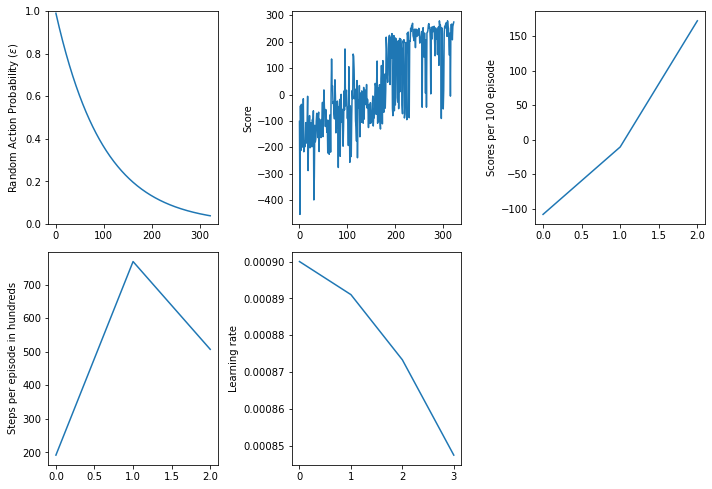

In [61]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 128,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 128, epsilon_decay = 0.99, LR_decay = True)

Episode 100	Average Score: -106.25	Average_#Stepsperepisode_last_100_episode: 200.10
Episode 200	Average Score: 9.83	Average_#Stepsperepisode_last_100_episode: 771.29
Episode 300	Average Score: 171.76	Average_#Stepsperepisode_last_100_episode: 561.06
Episode 340	Average Score: 201.08
Environment solved in 240 episodes!	Average Score: 201.08


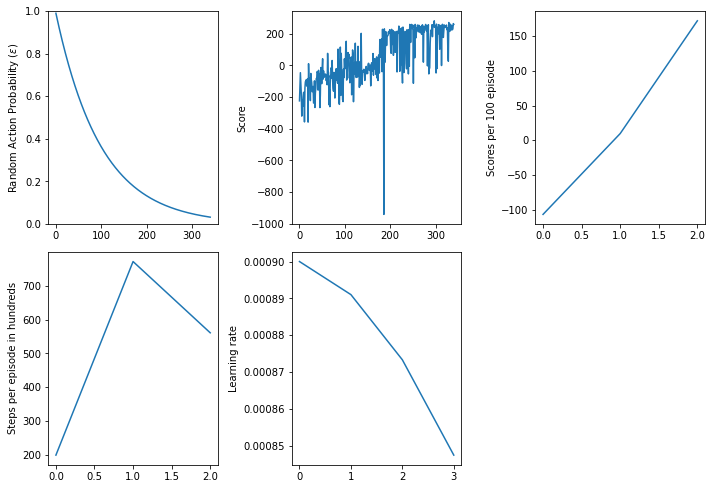

In [62]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 256,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 256, epsilon_decay = 0.99, LR_decay = True)

Episode 100	Average Score: -103.26	Average_#Stepsperepisode_last_100_episode: 156.54
Episode 200	Average Score: -47.70	Average_#Stepsperepisode_last_100_episode: 631.64
Episode 300	Average Score: 100.08	Average_#Stepsperepisode_last_100_episode: 720.81
Episode 400	Average Score: 166.12	Average_#Stepsperepisode_last_100_episode: 608.97
Episode 432	Average Score: 201.55
Environment solved in 332 episodes!	Average Score: 201.55


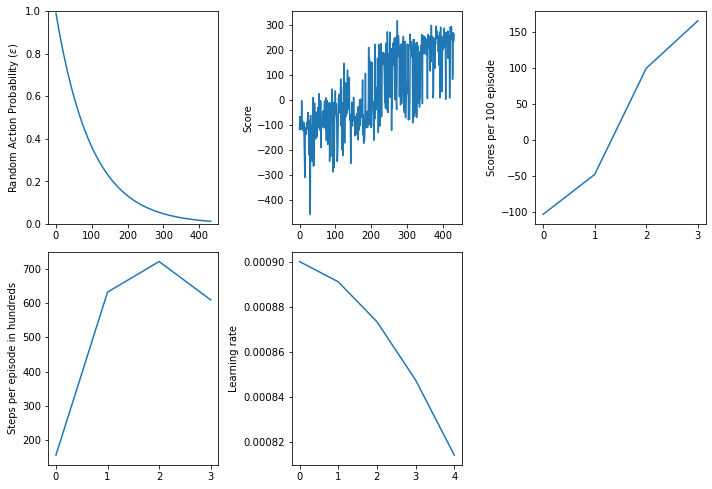

In [12]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 512,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 512, epsilon_decay = 0.99, LR_decay = True)

#### Conclusion:
1. We can see that the as the batch size increases the performance of the agent increases, but does not improve much after an upper limit is crossed.
2. The size of the batch is very crucial to the performance of the agent, to big a size and we lose performance.
3. We also see that the repeatibilty of results is problem, with the batch size as 64 tested again gives a different result.
4. We will go ahead with a batch size of 128 from here on, since it gives better performance than with a batch size of 64

#### Tau
We know from "Continuous control with deep reinforcement learning" - by Timothy P. Lillicrap et. al. 2019[8] that the weights of these target networks are then updated by having them slowly track the learned networks:
θ' = θ × τau + θ' × (1−τau) with τ << 1.
Now since the value of Tau is very low we have to update the target network frequently so as to have any significant effect, so every time local network learns the target network will be updated.
So we'll start with lower value of Tau
1. Tau = 0.0001
2. Tau = 0.1

In [13]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 128,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.0001, batch_size = 128, epsilon_decay = 0.99, LR_decay = True)

Episode 100	Average Score: -127.42	Average_#Stepsperepisode_last_100_episode: 175.81
Episode 200	Average Score: -79.65	Average_#Stepsperepisode_last_100_episode: 325.52
Episode 300	Average Score: -27.45	Average_#Stepsperepisode_last_100_episode: 294.21
Episode 400	Average Score: 22.08	Average_#Stepsperepisode_last_100_episode: 340.48
Episode 500	Average Score: 5.89	Average_#Stepsperepisode_last_100_episode: 346.88
Episode 600	Average Score: 54.73	Average_#Stepsperepisode_last_100_episode: 396.91
Episode 700	Average Score: 69.59	Average_#Stepsperepisode_last_100_episode: 578.91
Episode 800	Average Score: -39.70	Average_#Stepsperepisode_last_100_episode: 929.73
Episode 900	Average Score: -81.05	Average_#Stepsperepisode_last_100_episode: 673.58
Episode 1000	Average Score: -103.76	Average_#Stepsperepisode_last_100_episode: 446.62
Episode 1100	Average Score: -96.74	Average_#Stepsperepisode_last_100_episode: 379.88
Episode 1200	Average Score: -98.82	Average_#Stepsperepisode_last_100_episode:

In [15]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 128,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.1, batch_size = 128, epsilon_decay = 0.99, LR_decay = True)

Episode 100	Average Score: -152.63	Average_#Stepsperepisode_last_100_episode: 151.75
Episode 200	Average Score: -506.16	Average_#Stepsperepisode_last_100_episode: 144.00
Episode 300	Average Score: -491.93	Average_#Stepsperepisode_last_100_episode: 112.24
Episode 400	Average Score: -834.55	Average_#Stepsperepisode_last_100_episode: 131.87
Episode 500	Average Score: -653.30	Average_#Stepsperepisode_last_100_episode: 92.58
Episode 600	Average Score: -561.26	Average_#Stepsperepisode_last_100_episode: 65.84
Episode 700	Average Score: -572.01	Average_#Stepsperepisode_last_100_episode: 66.68
Episode 800	Average Score: -588.23	Average_#Stepsperepisode_last_100_episode: 66.66
Episode 900	Average Score: -573.60	Average_#Stepsperepisode_last_100_episode: 67.15
Episode 1000	Average Score: -557.39	Average_#Stepsperepisode_last_100_episode: 66.31
Episode 1100	Average Score: -591.58	Average_#Stepsperepisode_last_100_episode: 67.82
Episode 1200	Average Score: -570.32	Average_#Stepsperepisode_last_100_

Episode 100	Average Score: -120.84	Average_#Stepsperepisode_last_100_episode: 178.85
Episode 200	Average Score: -7.37	Average_#Stepsperepisode_last_100_episode: 783.60
Episode 300	Average Score: 181.69	Average_#Stepsperepisode_last_100_episode: 551.68
Episode 315	Average Score: 200.03
Environment solved in 215 episodes!	Average Score: 200.03


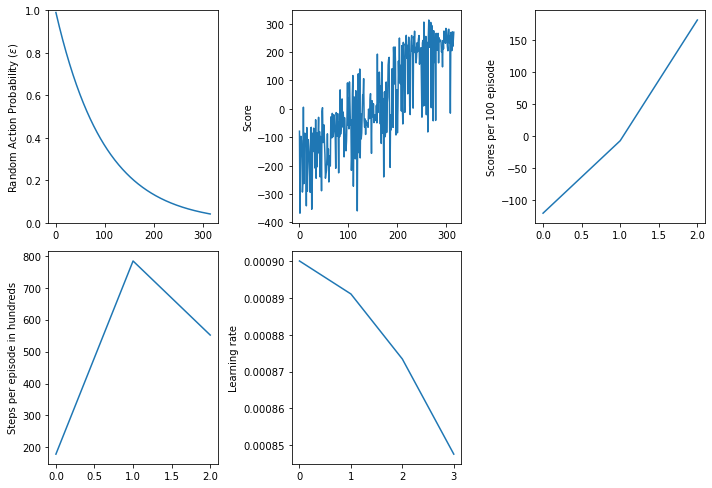

In [16]:
agent = Agent(state_size=8, action_size=4, buffer_size = 100000, batch_size = 128,
              LR = 0.0009,LR_decay_rate = 0.01, Error_Type = 'huber_loss')

train(n_episodes=2000, max_steps_per_episode=1000, epsilon=1.0, final_epsilon=0.001, update_every = 4,
      gamma = 0.9999, tau = 0.001, batch_size = 128, epsilon_decay = 0.99, LR_decay = True)

#### Conclusion:
1. We can say that as the value of tau increases or decreases the performance of the agent deteriorates and is not able to slove the problem.
2. But with tau = 0.001 we get a good result, This is because the value of Tau is selected in conjunction with value for update_every, and changing tau without changing update_every would not give good results as seen above

### 6. Project Report Conclusion

1. Between episodes 0 to 100 the agent learns to not directly free fall without using any of the engine, so we see a lower number of average steps per 100 episode for the first 100 episodes.


2. As we have seen with our agents performance the number of steps increases in the interval between 100 and 200 episodes, this is where the agent learns to fly, which is then further optimized to get a lower number of steps used since flying uses main engine for altitude and speed adjustment and the side engines for attitude adjustment and it costs more reward.


3. In the interval between episode 200 and 300 we see that the number of steps can be seen to be decreasing gradually and the agent achieves a minima to get to land on the target pad with fewer number of steps increasing its total average score per episode.


4. The selection of hyperparameters for a reinforcement learning agent is a daunting task as there is always the case where repeatibility of results is difficult.


5. The agent achieves a high positive average reward for 100 consecutive episodes and so the environment is considered to be solved by our RL agent.

### Future Work

1. An implmentation of Combined Experience Replay - "A Deeper Look at Experience Replay" by Shangtong Zhang, Richard S. Sutton 2018 [2], can be experimented with to test the agents performance.


2. Using MellowMax to eliminate the need of a target network and test the agents performance.


3. Addition of observation space noise and engine failure criteria to test for robustness of the trained agent.

### Citation
1.  https://arxiv.org/pdf/1312.5602.pdf
2.  https://www.endtoend.ai/assets/blog/paper-unraveled/cer/original.pdf
3.  https://www.ijcai.org/proceedings/2019/0379.pdf
4.  https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py
5.  https://gym.openai.com/docs/#environments
6.  https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
7.  https://www.endtoend.ai/paper-unraveled/cer/
<!-- 8.  https://towardsdatascience.com/deep-q-network-dqn-ii-b6bf911b6b2c -->
8. https://arxiv.org/abs/1509.02971
9.  https://medium.com/analytics-vidhya/learning-rate-decay-and-methods-in-deep-learning-2cee564f910b
10. http://www.incompleteideas.net/lin-92.pdf
11. https://towardsdatascience.com/simple-reinforcement-learning-q-learning-fcddc4b6fe56
12.https://nbviewer.org/url/www.cs.colostate.edu/~anderson/cs545/notebooks/16%20Reinforcement%20Learning%20with%20Neural%20Network%20as%20Q%20Function.ipynb
13. https://greentec.github.io/reinforcement-learning-third-en/
<!-- 14. https://arxiv.org/abs/1509.02971 -->
14. https://pytorch.org/docs/stable/generated/torch.nn.HuberLoss.html
15.https://nbviewer.org/url/www.cs.colostate.edu/~anderson/cs545/notebooks/19%20Reinforcement%20Learning%20Modular%20Framework.ipynb